# Is our Puppet capable?
- In the *binary classification* fine-tuning guided exercise, we worked with a relatively simple dataset (fake vs. true news). Because of the structure and cleanliness of that dataset, our fine-tuned model performed extremely well. That’s not always the case, though many real-world datasets are noisy, inconsistently formatted, or contain labels that are highly subjective. To succeed in those situations, you need more extensive pre-processing, careful data handling, and often quite a bit of trial and error in your training setup
- For this next task, we will be working with the [LIAR-PLUS](https://github.com/Tariq60/LIAR-PLUS) dataset, which is dataset introduced in the [Liar, Liar Pants on Fire](https://aclanthology.org/P17-2067/) paper

# Imports

In [12]:
import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')

#### Loading our data and cleaning it
- The [LIAR-PLUS](https://github.com/Tariq60/LIAR-PLUS) dataset is formed of 3 tsv files (`train.csv`, `val.csv` and `test.csv`)
- This is the description of the entries according to the creator:
    - Column 1: the ID of the statement ([ID].json).
    - Column 2: the **label**.
    - Column 3: the **statement**.
    - Column 4: the subject(s).
    - Column 5: the speaker.
    - Column 6: the speaker's job title.
    - Column 7: the state info.
    - Column 8: the party affiliation.
    - Columns 9-13: the total credit history count, including the current statement.
        - 9: barely true counts.
        - 10: false counts.
        - 11: half true counts.
        - 12: mostly true counts.
        - 13: pants on fire counts.
    - Column 14: the context (venue / location of the speech or statement).
    - Column 15: the extracted justification
##### What we actually need:
- For the fine-tuning of our model we will only be needing the `statement` and the `label`, so let's do some quick data cleaning
- Tasks:
    - Task 1: we want to finish the implementation of the `load_label_text_tsv` function, fields in tsv are tab seperated, you have the description of the dataset, do your work
    - Task 2: you will end up with few data points that have the label as a `'nan'` string (not `None`), remove those, we won't need them

In [2]:
def load_label_text_tsv(path):
    df = pd.read_csv(path, sep="\t", header=None, dtype=str)
    if df.shape[1] < 4:
        raise ValueError(f"File {path} has fewer than 4 columns.")
    out = pd.DataFrame({
        # --- Task 1 begins here ---
        "label": df.iloc[:, 2].astype(str).str.strip(),
        "text":  df.iloc[:, 3].astype(str).str.strip()
        # --- Task 1 ends here ---
    })
    return out


train_df = load_label_text_tsv('conspiracy/train.tsv')
val_df   = load_label_text_tsv('conspiracy/val.tsv')
test_df  = load_label_text_tsv('conspiracy/test.tsv')

# drop labels with 'nan' label
# --- Task 2 begins here ---
train_df = train_df[train_df['label'] != 'nan'].reset_index(drop=True)
val_df   = val_df[val_df['label'] != 'nan'].reset_index(drop=True)
test_df  = test_df[test_df['label'] != 'nan'].reset_index(drop=True)
# --- Task 2 ends here ---

print(train_df.head())

         label                                               text
0        false  Says the Annies List political group supports ...
1    half-true  When did the decline of coal start? It started...
2  mostly-true  Hillary Clinton agrees with John McCain "by vo...
3        false  Health care reform legislation is likely to ma...
4    half-true  The economic turnaround started at the end of ...


#### Textual labels are for humans, not for our Puppet
- Let's say you have 3 labels: "Salty", "Sweet", "Bland", it's better to call them 0 (for "Salty"), 1 (for "Sweet"), 2 (for "Bland")
- Tasks:
    - Task 1: get our labels
    - Task 2: build 2 dictionaries `label2id` (label is key, id is value), `id2label` (id is key, label is value)
    - Task 3: create a new field for your dataframes for our ids (Hint: what did you create in Task 2)

In [3]:
# --- Task 1 begins here ---
unique_labels = train_df['label'].unique()
# --- Task 1 ends here ---

# --- Task 2 begins here ---
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}
# --- Task 2 ends here ---

print('Label → ID mapping:', label2id)

# --- Task 3 begins here ---
train_df['label_id'] = train_df['label'].map(label2id)
val_df['label_id']   = val_df['label'].map(label2id)
test_df['label_id']  = test_df['label'].map(label2id)
# --- Task 3 ends here ---

Label → ID mapping: {'false': 0, 'half-true': 1, 'mostly-true': 2, 'true': 3, 'barely-true': 4, 'pants-fire': 5}


#### To HuggingFace dataset
- We want to transform our dataframe to a HuggingFace dataset
- Tasks:
    - Task 1: finish the implementation of `hf_format`, this method takes a dataframe, only it should only keep `text` and `label_id`

In [4]:
def hf_format(df):
    # --- Task 1 begins here ---
    return Dataset.from_pandas(df[['text','label_id']], preserve_index=False)
    # --- Task 1 ends here ---

dataset = DatasetDict({
    'train': hf_format(train_df),
    'validation': hf_format(val_df),
    'test': hf_format(test_df)
})

print(dataset['train'][0]['text'])

Says the Annies List political group supports third-trimester abortions on demand.


#### Tokenize the dataset
- We will be using `bert-base-uncased` as our model
- Tasks:
    - Task 1: initialize our `tokenizer`
    - Task 2: create our tokenized dataset
    - Task 3: set the dataset format to torch

In [5]:
# --- Task 1 begins here ---
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# --- Task 1 ends here ---

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=256)

# --- Task 2 begins here ---
dataset = dataset.map(tokenize, batched=True)
# --- Task 2 ends here ---

dataset = dataset.remove_columns(['text'])
dataset = dataset.rename_column('label_id','labels')

# --- Task 3 begins here ---
dataset.set_format('torch')
# --- Task 3 ends here ---

Map:   0%|          | 0/10240 [00:00<?, ? examples/s]

Map:   0%|          | 0/1284 [00:00<?, ? examples/s]

Map:   0%|          | 0/1267 [00:00<?, ? examples/s]

#### Creating a baseline using our non fine-tuned model
- The model is initialized
- Tasks:
    - Task 1: set the baseline model to evaluating mode
    - Task 2: get the model prediction (Hint: this is a multi class problem, what do we need?)
    - Task 3: get the true labels

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Baseline Evaluation: 100%|██████████| 159/159 [00:17<00:00,  9.24it/s]



Baseline (Before Fine-Tuning)
              precision    recall  f1-score   support

       false       0.40      0.01      0.02       249
   half-true       0.23      0.55      0.32       265
 mostly-true       0.21      0.54      0.30       241
        true       0.50      0.00      0.01       208
 barely-true       0.00      0.00      0.00       212
  pants-fire       0.00      0.00      0.00        92

    accuracy                           0.22      1267
   macro avg       0.22      0.18      0.11      1267
weighted avg       0.25      0.22      0.13      1267



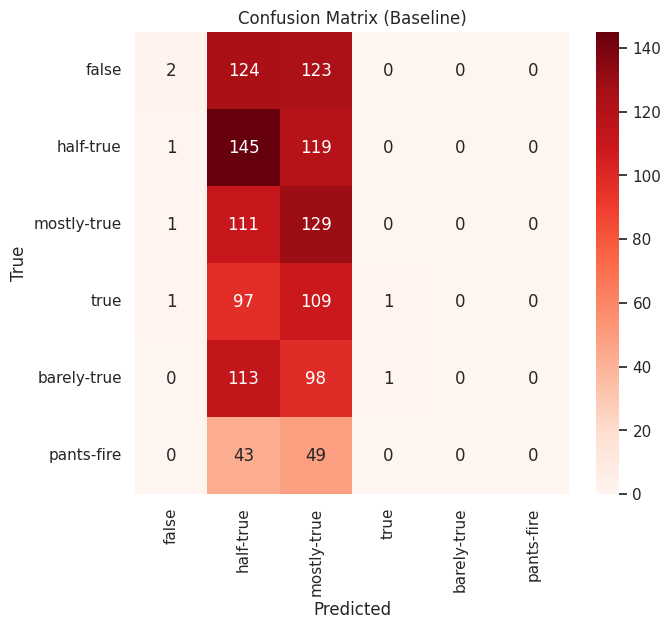

In [6]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
baseline_model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
).to(device)

test_loader = torch.utils.data.DataLoader(dataset['test'], batch_size=8)
logits_all = []

# --- Task 1 begins here ---
baseline_model.eval()
# --- Task 1 ends here ---

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Baseline Evaluation"):
        batch = {k: v.to(device) for k,v in batch.items()}
        outputs = baseline_model(**batch)
        logits_all.append(outputs.logits.cpu())

logits = torch.cat(logits_all, dim=0)

# --- Task 2 begins here ---
baseline_preds = torch.argmax(logits, dim=1).numpy()
# --- Task 2 ends here ---

# --- Task 3 begins here ---
true_labels = dataset['test']['labels']
# --- Task 3 ends here ---

print("\nBaseline (Before Fine-Tuning)")


print(classification_report(true_labels, baseline_preds, target_names=unique_labels))

cm = confusion_matrix(true_labels, baseline_preds)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix (Baseline)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### We load the model

In [7]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Training Setup
- Usually when training/fine-tuning a model, we observe the dev (some call the val set) and we try to optimize our hyperparameters to enhance the model performance (while avoiding overfitting)
- Tasks:
    - Task 1: initialize the `trainer`

In [8]:
TRAIN_BATCH_SIZE = 8
EVAL_BATCH_SIZE = 8
EPOCHS = 1
LR = 3e-5
WEIGHT_DECAY = 0.01

training_args = TrainingArguments(
    output_dir='./bert_6class_output',
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=EVAL_BATCH_SIZE,
    num_train_epochs=EPOCHS,
    learning_rate=LR,
    weight_decay=WEIGHT_DECAY,
    logging_steps=50,
    save_strategy='epoch',
    report_to='none'
)

trainer = Trainer(
    # --- Task 1 begins here ---
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation']
    # --- Task 1 ends here --
)

#### Let the training begin!

In [9]:
trainer.train()

Step,Training Loss
50,1.794400
100,1.773900
150,1.763600
200,1.738500
250,1.736600
300,1.734000
350,1.736300
400,1.758200
450,1.739500
500,1.743000


TrainOutput(global_step=1280, training_loss=1.7273710548877717, metrics={'train_runtime': 522.9983, 'train_samples_per_second': 19.579, 'train_steps_per_second': 2.447, 'total_flos': 1347176984739840.0, 'train_loss': 1.7273710548877717, 'epoch': 1.0})

#### Let's see the results


After Fine-Tuning
              precision    recall  f1-score   support

       false       0.29      0.36      0.32       249
   half-true       0.22      0.32      0.26       265
 mostly-true       0.23      0.35      0.28       241
        true       0.29      0.17      0.22       208
 barely-true       0.31      0.08      0.13       212
  pants-fire       0.37      0.08      0.13        92

    accuracy                           0.25      1267
   macro avg       0.28      0.23      0.22      1267
weighted avg       0.27      0.25      0.24      1267



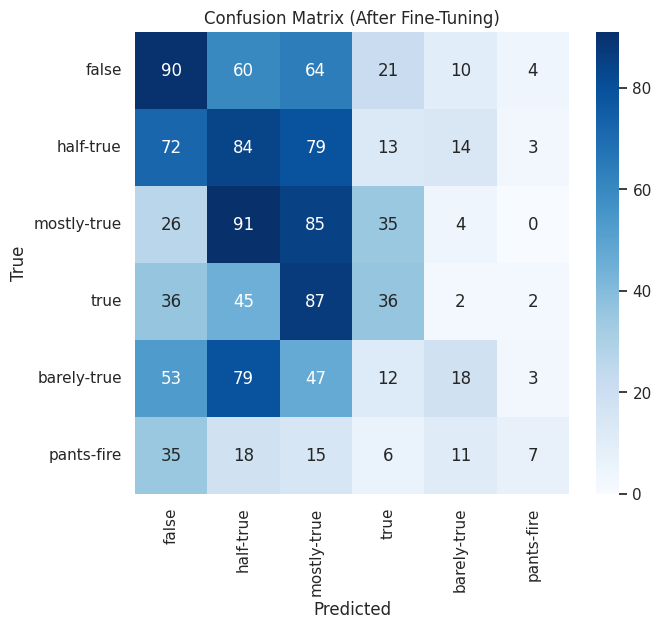

In [11]:
pred_output = trainer.predict(dataset['test'])
pred_labels = np.argmax(pred_output.predictions, axis=1)
true_labels = dataset['test']['labels']

print("\nAfter Fine-Tuning")
print(classification_report(true_labels, pred_labels, target_names=unique_labels))

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (After Fine-Tuning)')
plt.show()

#### What????
- If you see low values compared to the guided exercise, don't be disappointed, the writers of the paper got even worse results!
- An encoder may not enough to solve such a task (a task that require prior knowledge, reasoning capabilities, etc...)